In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random as ra
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from matplotlib.ticker import FuncFormatter
import diptest
from scipy.stats import skew, kurtosis
import math

plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

This is the code for Figure 1 in the main text. All datafiles are in a folder named "Data".

Datafiles details are below:

WormMYb - datafile with bacterial loads inside the worm for all the species  
invMYb -  datafile with bacterial growth outside the worm  
MYb71 - datafile with bacterial loads for the species MYb71  
MYb120 - datafile with bacterial loads for the species MYb120  


In [2]:
def plot_code1():
    
    # Load the data from CSV files with correct filepath
    WormMYb = pd.read_csv("../Data/MYbSpecies.csv")
    invMYb = pd.read_csv("../Data/invitro_082819.csv")

    # Define bacteria list, selct timepoints, and color palette
    
    bacteria_list = ['MYb27', 'MYb45', 'MYb53', 'MYb71', 'MYb120', 'MYb238', 'MYb181']
    selected_timepoints = [3, 12, 18, 24, 36, 42, 48]

    color_palette = {'MYb27': 'red', 'MYb45': 'green', 'MYb53': 'blue', 'MYb71': 'magenta',
                     'MYb120': 'orangered', 'MYb238': 'brown', 'MYb181': 'pink'}

    means = []
    stds = []

   
    # Process each bacteria and calculate means and stdevs at selected timepoints
    for bacteria in bacteria_list:
        bacteria_columns = [f"{bacteria}_{j}" for j in range(1, 7)]
        bacteria_data = invMYb[bacteria_columns]

        selected_data = bacteria_data[invMYb['T_hours'].isin(selected_timepoints)]

        mean_data = selected_data.mean(axis=1)
        std_data = selected_data.std(axis=1)

        means.append(mean_data)
        stds.append(std_data)

        plt.scatter(mean_data, std_data, alpha=0.7, label=bacteria, s=50, marker='d', color=color_palette[bacteria])

    #Plotting settings grouped by bacteria type
    
    result = WormMYb.groupby(['MYbSp', 'Time'])['CFU'].agg(['mean', 'std']).reset_index()
    result['std_over_mean'] = result['std'] / result['mean']
    scatter_plot = sns.scatterplot(x='mean', y='std_over_mean', marker="o", s = 90, hue='MYbSp', legend=False, data=result,
                                   palette=color_palette)

    legend_elements = [
        Line2D([0], [0], marker='d', color='w', label='in vitro', markerfacecolor='k', markersize=11),
        Line2D([0], [0], marker='o', color='w', label='in vivo', markerfacecolor='k', markersize=11), ]

    legend_markers = plt.legend(handles=legend_elements, title='Environment', fontsize=16, loc='upper left', title_fontsize = 16)

    plt.gca().add_artist(legend_markers)

    plt.plot([0, 1000000], [1, 1], color='gray', linestyle='--')
    plt.legend(title='Species ID', fontsize=15, loc="upper right", ncol =2, title_fontsize = 15)
    
    plt.xlabel(r'$\mu$', fontsize=24)
    plt.ylabel(r'$\sigma/\mu$', fontsize=24)
    plt.tick_params(axis='both', which='both', labelsize=22)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(0.01, 1000000)
    plt.ylim(0.0001, 100000)
    



In [3]:
def plot_code2():
    
    # Load and preprocess the data - reshaping requires (7,24) shape because there are 7 timepoints for this bacteria
    
    MYb71 = pd.read_csv("../Data/MYb71.csv", delimiter=",") 
    data = MYb71.dropna()
    
    t_data = data["Time"].to_numpy()
    N_data = data["logCFU"].to_numpy()

    Ndata_raw = MYb71["CFU"].to_numpy()
    tdata_raw = MYb71["Time"].to_numpy()

    newvar = np.log10(np.maximum(1, Ndata_raw).reshape(7, 24))

    tset = [3, 12, 18, 24, 36, 42, 48]
    MYb71df1 = np.array(MYb71);
    MYb71_m = MYb71df1.reshape(7, 24, 4)
    
    #calculate statistics of the data

    means = np.zeros(7)
    stds = np.zeros(7)

    
    for i in range(7):
        stats_data = np.array(MYb71_m[i,:,-1], dtype =float)
        n = len(np.array(MYb71_m[i,:,-1], dtype =float))

        means[i] = np.nanmean(stats_data)
        stds[i] = np.nanstd(stats_data)
        
    print("MYb71 Stats for T48 log(data):")
    print("mean, std =",np.round(means[6],2), 
          "&", np.round(stds[6],2))
    
    
    # Define the fitting function
    
    def fitfunc(t,V,c,b,d):
        def meanfieldeq(N,t,V,c,b,d):
            return c*(1-(N/V)) + b*(N)*(1-(N/V)) - d*(N)

        N0 = 0.00001
        result = odeint(meanfieldeq,N0,t, args = (V,c,b,d))
        return np.log10(result[:,0])
    
    # Fit the model to the data

    c_fit, ccov = curve_fit(fitfunc, t_data, N_data, p0= [100000,1, 1, 1], bounds=(0,10000000))
    print("MYb71Parameter values:")
    print("V, c, b, d =", np.round(c_fit[0], 2), "& ", np.round(c_fit[1], 2), "& ",
                np.round(c_fit[2], 2) ,"& ", np.round(c_fit[3], 2))
    #print(ccov)
    tfit = np.linspace(0,50);
    fit = fitfunc(tfit, c_fit[0], c_fit[1], c_fit[2], c_fit[3])
    
    
    # Gillespie simulations using the stochastic model

    expnum = 30
    tottime = 48
    tstep = 1 / 4
    tpnum = int(tottime / tstep)

    newtime = np.arange(0, tottime, tstep)

    gil = np.zeros((expnum, tpnum))

    for expt in range(expnum):
        
        
        t = 0.0
        N = 0.0
        V = c_fit[0]
        c = c_fit[1]
        b = c_fit[2]
        d = c_fit[3]

        step = 0

        while t < tottime:

            if t >= step * tstep:
                while step * tstep <= t:
                    gil[expt, step] = N
                    step = step + 1

            E = V - N
            a1 = c * (E / V)
            a2 = b * E * (N / V)
            a3 = d * N
            a = a1 + a2 + a3
            r1 = ra.uniform(0, 1)
            r2 = ra.uniform(0, 1)
            tau = 1 / a * math.log(1 / r1)
            t = t + tau
            targeta = a * r2
            if targeta < a1:
                N = N + 1
            elif targeta < a1 + a2:
                N = N + 1
            else:
                N = N - 1

            if N <= 0:
                #break
                N = 0

    # Solve deterministic model
    
    V = c_fit[0]
    def meanfieldeq(Ndet,tdet):
        return c*(1-(Ndet/V)) + b*(Ndet)*(1-(Ndet/V)) - d* (Ndet)

    tdet = np.linspace(0,50,1000)
    N0 = 1.0

    detsol = np.log10(odeint(meanfieldeq,N0,tdet))
    
    # Plot the results against the data
    
    for i in range(len(np.unique(tdata_raw))):
        violin = plt.violinplot(newvar[i, :][~np.isnan(newvar[i, :])], positions=np.array([np.unique(tdata_raw)[i]]),
                                 bw_method=0.3, showextrema=False, showmeans=False, widths=4, )

        for part in violin['bodies']:
            part.set_facecolor('magenta')

    plt.scatter(t_data+ np.random.uniform(-1.4, 1.4, size=len(t_data)),np.maximum(0,N_data), s=30,  label='MYb71', 
                alpha =0.6, color = 'magenta')
    

    plt.plot(newtime, np.log10(np.transpose(gil[0, :])), '-', label='stochastic', color='cornflowerblue',linewidth=1.5)
    plt.plot(newtime, np.log10(np.transpose(gil[1:, :])), '-', color='cornflowerblue')
    
    plt.plot(tset, means, 'p', label='Mean CFU', markersize=10, color='navy')
    plt.plot(tdet, detsol, '--', label='deterministic', linewidth=2, color='black')

    
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(loc='upper left', fontsize=10.5, ncol =2)
    plt.xlabel("Time (h)", fontsize=24)
    plt.ylim(-0.3, 6.8)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(x)}}}$'))
    plt.xlim(0, 50)
    plt.ylabel("CFU/worm", fontsize=24)

    
    
def plot_code3():
    
    # Load and preprocess the data - reshaping requires (6,24) shape because there are 6 timepoints for this bacteria
    
    MYb120 = pd.read_csv("../Data/MYb120.csv", delimiter=",") 
    data = MYb120.dropna()
    
    t_data = data["Time"].to_numpy()
    N_data = data["logCFU"].to_numpy()

    Ndata_raw = MYb120["CFU"].to_numpy()
    tdata_raw = MYb120["Time"].to_numpy()

    newvar = np.log10(np.maximum(1, Ndata_raw).reshape(6, 24))

    tset = [12, 18, 24, 36, 42, 48]
    MYb120df1 = np.array(MYb120);
    MYb120_m = MYb120df1.reshape(6,24,4)
    
    #calculate statistics of the data
    means = np.zeros(6)
    stds = np.zeros(6)

    
    for i in range(6):
        stats_data = np.array(MYb120_m[i,:,-1], dtype =float)
        n = len(np.array(MYb120_m[i,:,-1], dtype =float))

        means[i] = np.nanmean(stats_data)
        stds[i] = np.nanstd(stats_data)

        
    print("MYb120 Stats for T48 log(data):")
    print("mean, std, =", np.round(means[5],2), 
          "&", np.round(stds[5],2))

    # Define the fitting function
    
    def fitfunc(t,V,c,b,d):
        def meanfieldeq(N,t,V,c,b,d):
            return c*(1-(N/V)) + b*(N)*(1-(N/V)) - d*(N)

        N0 = 0.00001
        result = odeint(meanfieldeq,N0,t, args = (V,c,b,d))
        return np.log10(result[:,0])
    
    # Fit the model to the data
    
    c_fit, ccov = curve_fit(fitfunc, t_data, N_data, p0= [100000,0.5, 0.5, 0.5], bounds=(0,10000000))
    print("MYb120 Parameter values:")
    print("V, c, b, d =", np.round(c_fit[0], 2), "& ", np.round(c_fit[1], 2), "& ",
                np.round(c_fit[2], 2) ,"& ", np.round(c_fit[3], 2))
    #print(ccov)
    tfit = np.linspace(0,50);
    fit = fitfunc(tfit, c_fit[0], c_fit[1], c_fit[2], c_fit[3])
    
    # Gillespie simulations using the stochastic model    
    
    expnum = 30
    tottime = 48
    tstep = 1 / 4
    tpnum = int(tottime / tstep)

    newtime = np.arange(0, tottime, tstep)

    gil = np.zeros((expnum, tpnum))

    for expt in range(expnum):
        
        t = 0.0
        N = 0.0
        V = c_fit[0]
        c = c_fit[1]
        b = c_fit[2]
        d = c_fit[3]

        step = 0

        while t < tottime:

            if t >= step * tstep:
                while step * tstep <= t:
                    gil[expt, step] = N
                    step = step + 1

            E = V - N
            a1 = c * (E / V)
            a2 = b * E * (N / V)
            a3 = d * N
            a = a1 + a2 + a3
            r1 = ra.uniform(0, 1)
            r2 = ra.uniform(0, 1)
            tau = 1 / a * math.log(1 / r1)
            t = t + tau
            targeta = a * r2
            if targeta < a1:
                N = N + 1
            elif targeta < a1 + a2:
                N = N + 1
            else:
                N = N - 1

            if N <= 0:
                #break
                N = 0
                
    # Solve deterministic model

    V = c_fit[0]
    def meanfieldeq(Ndet, tdet):
        return c * (1 - (Ndet / V)) + b * (Ndet) * (1 - (Ndet / V)) - d * (Ndet)

    tdet = np.linspace(0, 50, 1000)
    N0 = 1.0

    detsol = np.log10(odeint(meanfieldeq, N0, tdet))
    
    # Plot the results against the data
    
    for i in range(len(np.unique(tdata_raw))):
        violin = plt.violinplot(newvar[i,:][~np.isnan(newvar[i,:])], positions = np.array([np.unique(tdata_raw)[i]]),
                       bw_method =0.3,showextrema = False, showmeans = False, widths=4,)

        for part in violin['bodies']:
            part.set_facecolor('orangered')
    
    
    plt.scatter(t_data+ np.random.uniform(-1.4, 1.4, size=len(t_data)),np.maximum(0, N_data), label='MYb120', 
            s=30, alpha=0.6, color='orangered')
    

    plt.plot(newtime, np.log10(np.transpose(gil[0,:])), '-', label = 'stochastic', color = 'cornflowerblue', linewidth = 1.5)
    plt.plot(newtime, np.log10(np.transpose(gil[1:,:])), '-', color = 'cornflowerblue')
    plt.plot(tset,means, 'p' , label = 'Mean CFU', markersize = 10, color = 'navy')
    plt.plot(tdet,detsol, '--', label = 'deterministic', linewidth = 2, color = 'black')

    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(loc='upper left', fontsize=10.5, ncol =2)
    plt.xlabel("Time (h)", fontsize=24)
    plt.ylim(-0.3, 6.8)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(x)}}}$'))
    plt.xlim(0, 50)



    

MYb71 Stats for T48 log(data):
mean, std = 4.63 & 0.55
MYb71Parameter values:
V, c, b, d = 17576.8 &  0.07 &  1.23 &  0.58


/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_5701/3605582701.py:134: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[0, :])), '-', label='stochastic', color='cornflowerblue',linewidth=1.5)
/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_5701/3605582701.py:135: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[1:, :])), '-', color='cornflowerblue')


MYb120 Stats for T48 log(data):
mean, std, = 2.14 & 0.67
MYb120 Parameter values:
V, c, b, d = 147.1 &  0.09 &  2.58 &  1.4


/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_5701/3605582701.py:283: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[0,:])), '-', label = 'stochastic', color = 'cornflowerblue', linewidth = 1.5)
/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_5701/3605582701.py:284: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[1:,:])), '-', color = 'cornflowerblue')


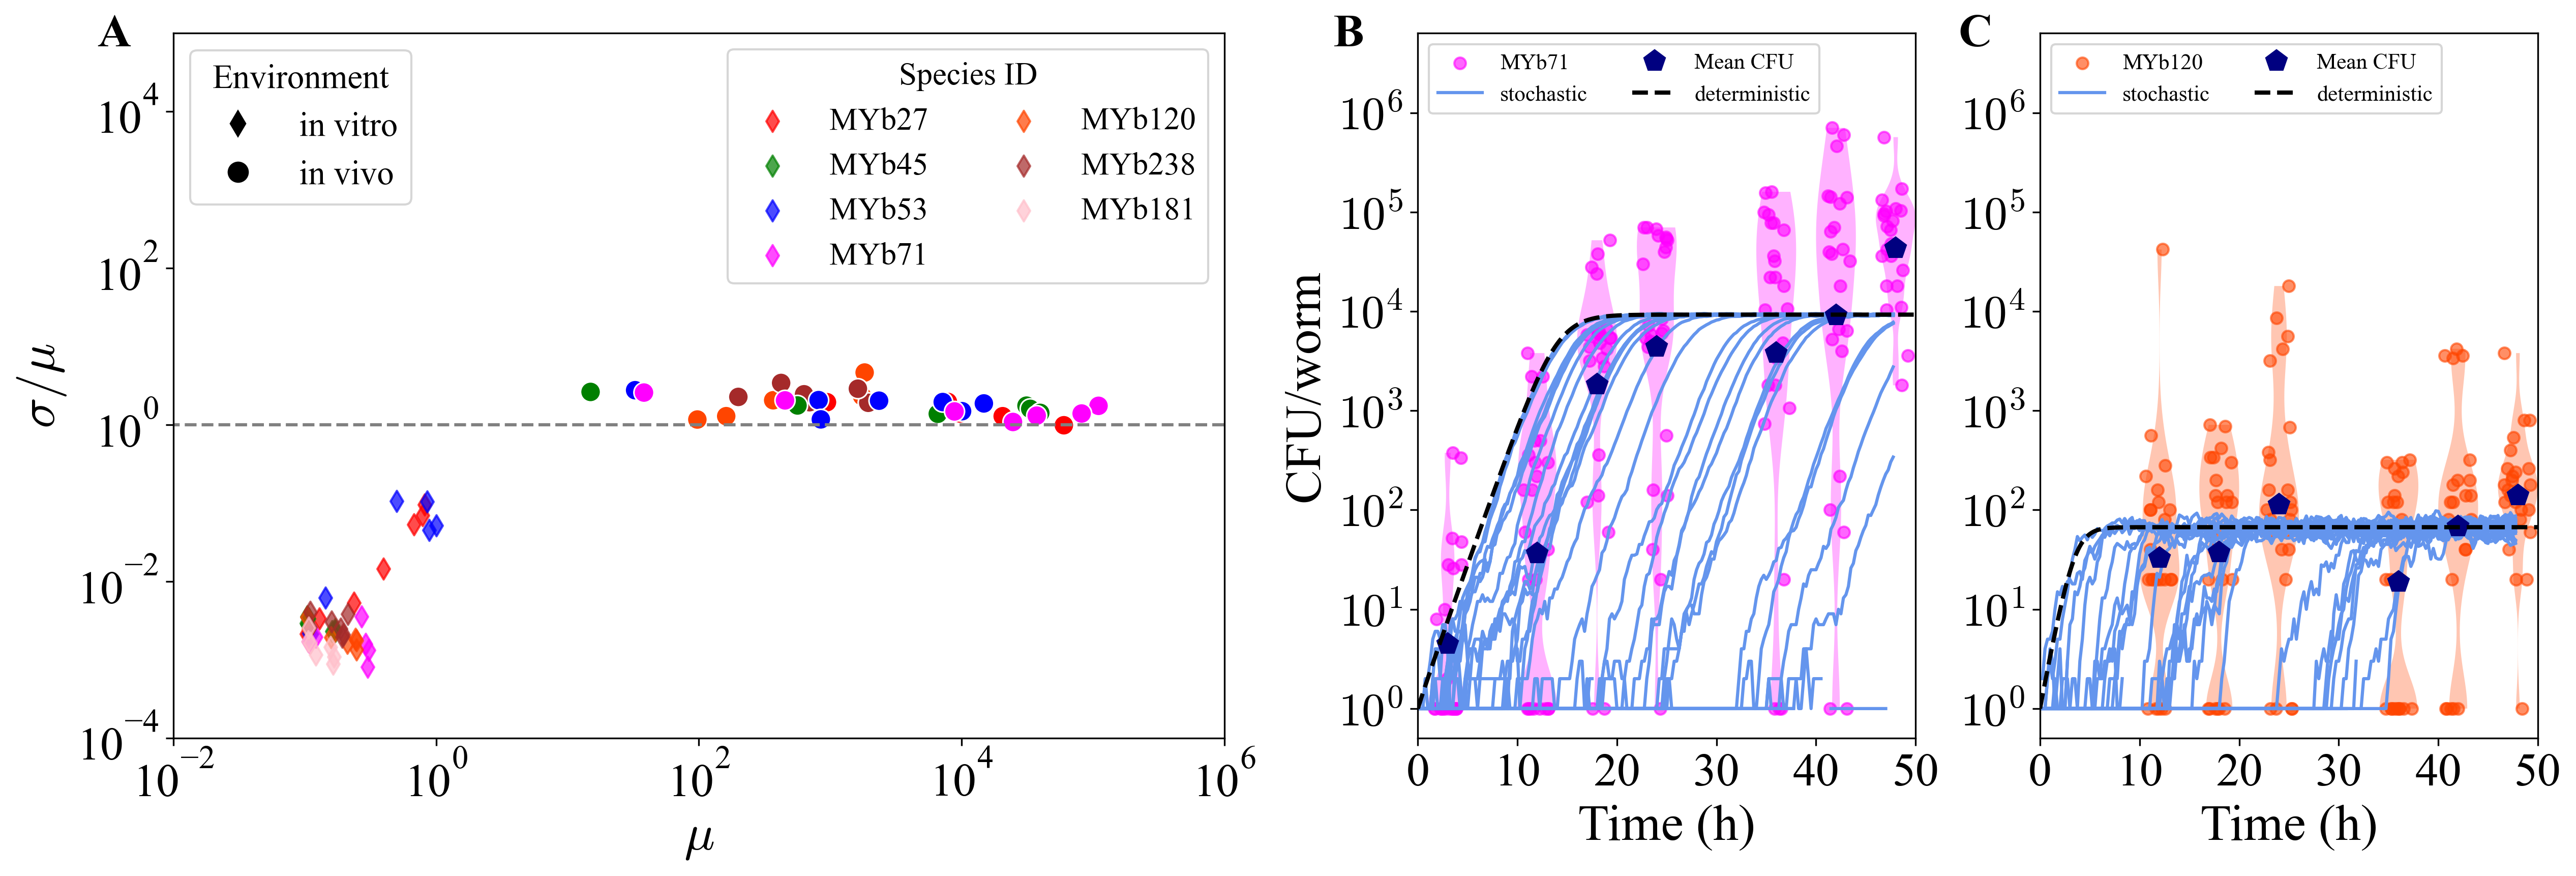

In [4]:
# Create a figure and plot using subplot function

fig = plt.figure(figsize=(20,6))

plt.subplot(1, 2, 1)
plot_code1()

plt.subplot(1, 4, 3)
plot_code2()

plt.subplot(1, 4, 4)
plot_code3()



fig.text(0.1, 0.90, "A", fontsize=22, va='top', ha='left',weight='bold')
fig.text(0.505, 0.90, "B", fontsize=22, va='top', ha='left',weight='bold')
fig.text(0.71, 0.90, "C", fontsize=22, va='top', ha='left',weight='bold')

plt.subplots_adjust(wspace=0.25)

plt.savefig("../Figures/WormMatters.pdf",dpi=300,  bbox_inches='tight')

plt.show()